# Approximating Implicit Matrix Factorization with Shallow Neural Networks

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
cd ..

/Users/willwolf/Documents/willwolf/dotify


# resources
- https://arxiv.org/pdf/1606.07674.pdf

In [4]:
# delete this eventually

import os

os.environ['SQLALCHEMY_DATABASE_URI'] = os.environ['DIGITAL_OCEAN_SQLALCHEMY_DATABASE_URI']

In [23]:
from collections import namedtuple
from copy import deepcopy
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sqlalchemy import create_engine

from dotify.config import DevelopmentConfig as Config
from dotify.recommendation.implicit_mf.ratings_matrix import RatingsMatrix
from dotify.recommendation.implicit_mf.implicit_mf import ImplicitMF
from dotify.resources.countries import countries as countries_lookup

ENGINE = create_engine(Config.SQLALCHEMY_DATABASE_URI)

%matplotlib inline
plt.style.use('seaborn')

# Abstract

## Implicit Matrix Factorization

The Implicit Matrix Factorization (IMF) algorithm as presented by [Hu, Koren and Volinksy](http://yifanhu.net/PUB/cf.pdf) is a widely popular, effective method for recommending items to users. This approach was born from necessity: while explicit feedback as to our users' tastes - a questionnaire completed at user signup, for example - makes building a recommendation engine straightforward, we often have nothing more than *implicit feedback* data - view count, click count, time spent on page, for example - which serve as nothing more than a proxy for these preferences. Crucially, the latter feedback is asymmetric: while a high view count might indicate positive preference for a given item, a low view count cannot be said to do the opposite. Perhaps, the user simply doesn't know the item is there.

IMF begins with a ratings matrix $R$, where $R_{u, i}$ gives the implicit feedback value observed for user $u$ and item $i$. Next, it constructs two other matrices defined as follows:

$$
p_{u, i} =
\begin{cases}
1 & r_{u, i} \gt 0\\
0 & r_{u, i} = 0
\end{cases}
$$
<br>
$$
c_{u, i} = 1 + \alpha r_{u, i}
$$

$P$ gives a binary matrix indicating our belief in the existence of each user's preference for each item. $C$ gives our *confidence* in the existence of each user's preference for each items where, trivially, larger values of $r_{u, i}$ give us higher confidence that user $u$ indeed likes item $i$.

Next, IMF outlines its goal: let's embed each user and item into $\mathbb{R}^f$ such that their dot product approximates the former's true preference for the latter. Finally, and naming user vectors $x_u \in \mathbb{R}^f$ and item vectors $y_i \in \mathbb{R}^f$, we compute the argmin of the following objective:

$$
\underset{x_{*}, y_{*}}{\arg\min}\sum\limits_{u, i}c_{u, i}\big(p_{u, i} - x_u^Ty_i\big)^2 + \lambda\bigg(\sum\limits_u\|x_u\|^2 + \sum\limits_i\|y_u\|^2\bigg)
$$

Once sufficiently minimized, we can compute expected preferences $\hat{p}_{u, i} = x_u^Ty_i$ for unobserved $\text{(user, item)}$ pairs; recommendation then becomes:
1. For a given user $u$, compute predicted preferences $\hat{p}_{u, i} = x_u^Ty_i$ for all items $i$.
2. Sort the list in descending order.
3. Returning the top $n$ items.

## Shallow neural networks
IMF effectively gives a function $f: u, i \rightarrow \hat{p}_{u, i}$. As before, our goal is to minimize the function above, which we can now rewrite as:

$$
\underset{x_{*}, y_{*}}{\arg\min}\sum\limits_{u, i}c_{u, i}\big(p_{u, i} - f(u, i)\big)^2 + \lambda\bigg(\sum\limits_u\|x_u\|^2 + \sum\limits_i\|y_u\|^2\bigg)
$$

To approximate this function, I turn to our favorite [universal function approximator](http://neuralnetworksanddeeplearning.com/chap4.html): neural networks optimized with gradient descent.

This work is built around a toy web application I authored long ago: [dotify](http://dotify.herokuapp.com/). At present, dotify:
- Pulls data nightly from [Spotify Charts](https://spotifycharts.com/regional). These data contain the number of streams for that day's top 200 songs for each of 55 countries.
- Computes an implicit matrix factorization nightly, giving vectors for both countries and songs.
- Allows the user to input a "country-arithmetic" expression, i.e. "I want music like `Colombia x Turkey - Germany`." It then performs this arithmetic with the chosen vectors and recommends songs to the composite.

In this work, I first fit and cross-validate an implicit matrix factorization model, establishing the three requisite parameters: $f$, the dimensionality of the latent vectors; $\alpha$, the scalar multiple used in computing $C$; $\lambda$ the regularization strength used in on our loss function.

### Network architectures

Next, I explore five different shallow neural network architectures in attempt to improve upon the observed results. These architectures are as follows:

1. A trivially "Siamese" network which first embeds each country and song index into $\mathbb{R}^f$ in parallel then computes a dot-product of the embeddings. This is roughly equivalent to what is being done by IMF.
2. Same as previous, but with a bias embedding for each set, in $\mathbb{R}$, added to the dot-product.
3. Same as #1, but concatenate the vectors instead. Then, stack 3 fully-connected layers with ReLU activations, batch normalization after each, and dropout after the first. Finally, add a 1-unit dense layer on the end, and add bias embeddings to the result. (NB: I wanted to add the bias embeddings to the respective $\mathbb{R}^f$ embeddings at the outset, but couldn't figure out how to do this in Keras.)
4. Same as #2, except feed in the song title text as well. This text is first tokenized, then padded to a maximum sequence length, then embedded into a fixed-length vector by an LSTM, then reduced to a single value by a dense layer with ReLU activation. Finally, this scalar is concatenated to the scalar output that #2 would produce, and the result is fed into a final dense layer with a linear activation - i.e. a linear combination of the two.
5. Same as #4, except feed in the song artist index as well. This index is first embedded into a vector, then reduced to a scalar by a dense layer with ReLu activation. Finally, this scalar is concatenated with the two scalars produced in the second-to-last layer of #4, then fed into a final dense layer with a linear activation. Like the previous, this is a linear combination of the three inputs.

# add the links in here

# Results

# Data preparation

To construct our ratings matrix, I take the sum of total streams for each $\text{(country, song)}$ pair. The data are limited to a given number of "top songs," defined as a song that appeared on Spotify Charts *on a given date*.

Because the values exist on wildly different orders of magnitude, I scale the results as follows:

$$\tilde{r}_{u, i} = \log{\bigg(\frac{1 + r_{u, i}}{\epsilon}\bigg)}$$

To start, let's build a ratings matrix for a small sample of the data.

In [7]:
ratings_matrix = RatingsMatrix(n_top_songs=10000, eps=1e3)
ratings_matrix.R_ui.head()

song_id,5552,5553,5555,5556,5557,5558,5560,5562,5565,5582,...,33063,33064,33065,33066,33067,33068,33069,33070,33071,33072
country_id,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.0,0.000000,0.0,4.045469,0.0,0.0,0.0,3.643437,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.587463,0.000000,0.0,0.000000,0.0,2.814270,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.000000,2.961865,0.0,2.859512,0.0,3.175760,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,1.138153,0.961264,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Next, let's get an idea of the sparsity of our data and how many songs each country has streamed.

In [13]:
sparsity = (ratings_matrix.R_ui == 0).mean().mean()
non_zero_entries_percent = 100*np.round(1 - sparsity, 4)

print('Our ratings matrix has {}% non-zero entries.'.format(non_zero_entries_percent))

Our ratings matrix has 7.32% non-zero entries.


In [31]:
print('Our ratings matrix has {} countries.'.format(ratings_matrix.R_ui.shape[0]))

Our ratings matrix has 55 countries.


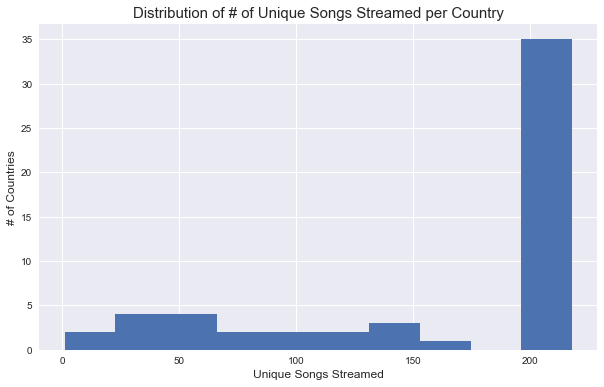

In [40]:
plt.figure(figsize=(10, 6))

songs_rated_by_country = (ratings_matrix.R_ui > 0).sum(axis=1)
plt.hist(songs_rated_by_country)
plt.title('Distribution of # of Unique Songs Streamed per Country', fontsize=15)
plt.xlabel('Unique Songs Streamed', fontsize=12)
_ = plt.ylabel('# of Countries', fontsize=12)

## Construct training, validation sets

In reviewing literature on recommender engine evaluation, it seems common to create training and validation sets as follows:
1. Filter your ratings matrix for users (countries) that meet some criterion, i.e. they've streamed above a certain threshold of songs.
2. Select a random $x\%$ of their items (songs).
3. "Move" these items into a validation matrix; set them to 0 in the training matrix.

To construct this split, I first compute a sensible threshold for Step #1, then "move" a random 20% of songs from the training matrix to the validation matrix.

In [47]:
print('The 15th percentile of songs rated by country is {}.'.format(
    np.percentile(songs_rated_by_country, 15)
))

The 15th percentile of songs rated by country is 54.5.


Let's choose 50 as our cutoff, and move 20% of the songs in qualifying rows to a validation set.

NB: The actual ratings matrix is located at `RatingsMatrix.R_ui`. This reflects the API choice I made when first starting this project.

In [48]:
more_than_50_ratings_mask = songs_rated_by_country > 50

In [49]:
FRACTION_TO_DROP = .2
TRAINING_MATRIX = ratings_matrix
VALIDATION_MATRIX = deepcopy(TRAINING_MATRIX)
VALIDATION_MATRIX.R_ui = pd.DataFrame(0., index=TRAINING_MATRIX.R_ui.index, columns=TRAINING_MATRIX.R_ui.columns)

for country_id, ratings in TRAINING_MATRIX.R_ui[more_than_50_ratings_mask].iterrows():
    
    rated_songs_mask = TRAINING_MATRIX.R_ui.ix[country_id] > 0
    rated_songs = TRAINING_MATRIX.R_ui.ix[country_id][rated_songs_mask].index.tolist()
    n_songs_to_drop = int( len(rated_songs)*FRACTION_TO_DROP )
    songs_to_drop = set( random.sample(rated_songs, n_songs_to_drop) )
    
    VALIDATION_MATRIX.R_ui.ix[country_id][songs_to_drop] = TRAINING_MATRIX.R_ui.ix[country_id][songs_to_drop]
    TRAINING_MATRIX.R_ui.ix[country_id][songs_to_drop] = 0.

# Evaluation

Evaluating recommender systems is an inexact science because there is no "right" answer. In production, this evaluation is often done via the A/B test of a proxy metric important to the business - revenue, for example. In training, the process is less clear. To this end, the authors of the IMF paper offer the following:

> Evaluation of implicit-feedback recommender requires appropriate measures. In the traditional setting where a user is specifying a numeric score, there are clear metrics such as mean squared error to measure success in prediction. However with implicit models we have to take into account availability of the item, competition for the item with other items, and repeat feedback. For example, if we gather data on television viewing, it is unclear how to evaluate a show that has been watched more than once, or how to compare two shows that are on at the same time, and hence cannot both be watched by the user.

Additionally, they state:

> It is important to realize that we do not have a reliable feedback regarding which programs are unloved, as not watching a program can stem from multiple different reasons. In addition, we are currently unable to track user reactions to our recommendations. Thus, precision based metrics are not very appropriate, as they require knowing which programs are undesired to a user. However, watching a program is an indication of liking it, making recall-oriented measures applicable.

In solution, they propose evaluating the "expected percentile ranking" defined as follows:

$$
\overline{\text{rank}} = \frac{\sum_{u, i}\tilde{r}_{u, i}^t\text{rank}_{u, i}}{\sum_{u, i}\tilde{r}_{u, i}^t}
$$

Here, $\text{rank}_{u, i}$ gives the percentile-ranking of the predicted preference, i.e. if $\hat{p}_{u = 17, i = 34}$ is the largest of all predicted preferences, then $\text{rank}_{u = 17, i = 34} = 0\%$. Similarly, the smallest of the predicted preferences, i.e. the last on the list, equals $100\%$.

The following class accepts a training matrix, validation matrix, and a matrix of predicted preferences. It then exposes the mean expected percentile ranking for both training and validation sets as properties on the instance.

In [50]:
class ExpectedPercentileRankingsEvaluator:
    
    def __init__(self, training_matrix, validation_matrix, predicted_preferences):
        self.training_matrix = training_matrix
        self.validation_matrix = validation_matrix
        self.predicted_preferences = predicted_preferences
        self._expected_percentile_rankings_train = []
        self._expected_percentile_rankings_validation = []
        
    def run(self):
        self._evaluate_train()
        self._evaluate_validation()

    def _evaluate_train(self):
        self._expected_percentile_rankings_train = self._evaluate(matrix=self.training_matrix)
        
    def _evaluate_validation(self):
        self._expected_percentile_rankings_validation = self._evaluate(matrix=self.validation_matrix)
        
    def _evaluate(self, matrix):
        expected_percentile_rankings = []
        for country_id, preferences in self.predicted_preferences[more_than_50_ratings_mask].iterrows():
            predictions = pd.DataFrame({
                'predicted_preference': preferences.sort_values(ascending=False),
                'rank': np.arange( len(preferences) ),
                'percentile_rank': np.arange( len(preferences) ) / len(preferences)
            })
            ground_truth = matrix.R_ui.ix[country_id][ matrix.R_ui.ix[country_id] > 0 ]
            numerator = (ground_truth * predictions['percentile_rank'][ground_truth.index]).sum()
            denominator = ground_truth.sum()
            expected_percentile_rankings.append( numerator / denominator )

        return expected_percentile_rankings

    @property
    def mean_expected_percentile_rankings_train(self):
        return np.mean(self._expected_percentile_rankings_train)
    
    @property
    def mean_expected_percentile_rankings_validation(self):
        return np.mean(self._expected_percentile_rankings_validation)

## Grid search

In [ ]:
F = 30
grid_search_results = {}
result = namedtuple('Result', 'alpha lmbda')

for alpha in [1e-1, 1e0, 1e1, 1e2]:
    for lmbda in [1e-1, 1e0, 1e1, 1e2]:
        implicit_mf = ImplicitMF(ratings_matrix=TRAINING_MATRIX, f=F, alpha=alpha, lmbda=lmbda)
        implicit_mf.run()
        predicted_preferences = implicit_mf.country_vectors.vectors.dot( implicit_mf.song_vectors.vectors.T )
        
        evaluator = ExpectedPercentileRankingsEvaluator(
            training_matrix=TRAINING_MATRIX,
            validation_matrix=VALIDATION_MATRIX,
            predicted_preferences=predicted_preferences
        )
        evaluator.run()
        grid_search_results[result(alpha=alpha, lmbda=lmbda)] = {
            'train': evaluator.mean_expected_percentile_rankings_train,
            'validation': evaluator.mean_expected_percentile_rankings_validation
        }

In [53]:
best_params = min(grid_search_results, key=lambda key: grid_search_results.get(key)['validation'])

In [ ]:
# train a final model

In [ ]:
ratings_matrix = RatingsMatrix(n_top_songs=1000000, eps=1e3)

In [ ]:
ratings_matrix.R_ui.shape

In [ ]:
# try "best_params.alpha, lmbda here"

implicit_mf = ImplicitMF(ratings_matrix=ratings_matrix, f=F, alpha=1, lmbda=25)
# implicit_mf.run()

# save stuff we care about from the final implicit mf run

In [ ]:
# implicit_mf.country_vectors.vectors.to_csv('data/country_vectors.csv')
# implicit_mf.song_vectors.vectors.to_csv('data/song_vectors.csv')
# implicit_mf.country_vectors.vectors = pd.read_csv('data/country_vectors.csv', index_col=['country_id'])
# implicit_mf.song_vectors.vectors = pd.read_csv('data/song_vectors.csv', index_col=['song_id'])

## Visualize

In [ ]:
country_vectors_df = implicit_mf.country_vectors.vectors

In [ ]:
# change countries index form id to name

In [ ]:
sns.set(style="white")

In [ ]:
country_id_to_name = {countries_lookup[name]['id']: name for name in countries_lookup}
country_ids = country_vectors_df.index
country_names = pd.Index([country_id_to_name[c_id] for c_id in country_ids], name='country_name')
country_vectors_df.index = country_names

In [ ]:
def plot_cosine_similarities(country_vectors_df):

    # compute the cosine similarity matrix
    similarities_df = pd.DataFrame(
        data=cosine_similarity(country_vectors_df),
        index=country_vectors_df.index,
        columns=country_vectors_df.index
    )
    
    # generate a mask for the upper triangle
    mask = np.zeros_like(similarities_df, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # set up the matplotlib figure
    f, ax = plt.subplots(figsize=(21, 21))

    # generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(similarities_df, mask=mask, cmap=cmap, vmax=.5,
                square=True, xticklabels=True, yticklabels=True,
                linewidths=1, cbar_kws={"shrink": .5}, ax=ax)

In [ ]:
plot_cosine_similarities(country_vectors_df)

# tsne

In [ ]:
from matplotlib import pylab
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

In [ ]:
country_embeddings = pd.DataFrame(
    data=tsne.fit_transform(country_vectors_df),
    index=country_vectors_df.index,
    columns=['dim_1', 'dim_2']
)

In [ ]:
def plot_tsne_embeddings(country_embeddings):

    pylab.figure(figsize=(15,15))

    for country_name, country_embedding in country_embeddings.iterrows():
        dim_1, dim_2 = country_embedding
        pylab.scatter(dim_1, dim_2)
        pylab.annotate(country_name, xy=(dim_1, dim_2), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
    pylab.show()

In [ ]:
plot_tsne_embeddings(country_embeddings)

## Inspect arithmetic combinations

In [ ]:
SONG_METADATA_QUERY = """
    SELECT 
        songs.title as song_title, 
        songs.artist as song_artist,
        songs.id as song_id
    FROM songs
"""

song_metadata_df = pd.read_sql(SONG_METADATA_QUERY, ENGINE, index_col=['song_id'])

In [ ]:
song_vectors_df = song_metadata_df.join(implicit_mf.song_vectors.vectors, how='inner')\
    .set_index(['song_title', 'song_artist'])

In [ ]:
song_vectors_df = song_vectors_df.apply(lambda vec: vec / np.linalg.norm(vec), axis = 1)
# normalize all country vectors here

In [ ]:
country_vec = country_vectors_df.ix['United States'] / np.linalg.norm(country_vectors_df.ix['United States'])

In [ ]:
pd.set_option('display.max_colwidth', 100)

In [ ]:
song_vectors_df.dot(country_vec).sort_values(ascending=False).reset_index().head(10)

In [ ]:
country_vec = country_vectors_df.ix['Colombia'] / np.linalg.norm(country_vectors_df.ix['Colombia'])
# country_vec = country_vectors_df.ix['Colombia']

In [ ]:
song_vectors_df.dot(country_vec).sort_values(ascending=False).reset_index().head(10)

In [ ]:
country_vec = country_vectors_df.ix['Germany'] / np.linalg.norm(country_vectors_df.ix['Germany'])
# country_vec = country_vectors_df.ix['Panama']

In [ ]:
song_vectors_df.dot(country_vec).sort_values(ascending=False).reset_index().head(10)

# hit it with the neural network

In [ ]:
from itertools import product

from keras import backend as K
from keras.layers import Input, Embedding, Flatten, Lambda, Dense, BatchNormalization, Dropout, LSTM
from keras.layers.merge import add, dot, concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.regularizers import l2

In [ ]:
alpha = 1
lmbda = 25
F = 30
LEARNING_RATE = .001

In [ ]:
P_ui = TRAINING_MATRIX.R_ui > 0
C_ui = 1 + alpha*TRAINING_MATRIX.R_ui

In [ ]:
def implicit_cf_loss(y_true, y_pred, alpha=alpha):
    P = y_true > 0
    C = 1 + alpha*y_true
    return K.mean( C*(P - y_pred)**2 )

## neatly arrange all the data

In [ ]:
song_metadata_df = song_metadata_df.ix[ratings_matrix.R_ui.columns]

In [ ]:
song_metadata_df.head()

In [ ]:
country_id_to_index = {c_id: index for index, c_id in enumerate(ratings_matrix.R_ui.index)}
song_id_to_index = {s_id: index for index, s_id in enumerate(ratings_matrix.R_ui.columns)}
song_artist_to_index = {artist: index for index, artist in enumerate(song_metadata_df['song_artist'].unique())}

In [ ]:
song_metadata_df['song_index'] = song_metadata_df.index.map(song_id_to_index.get)
song_metadata_df['song_artist_index'] = song_metadata_df['song_artist'].map(song_artist_to_index.get).astype(int)

In [ ]:
song_metadata_df.head()

In [ ]:
NUM_WORDS = 5000

In [ ]:
tokenizer = Tokenizer(num_words=NUM_WORDS, lower=True, split=" ")
tokenizer.fit_on_texts(song_metadata_df['song_title'])
song_metadata_df['title_sequence'] = tokenizer.texts_to_sequences(song_metadata_df['song_title'])

In [ ]:
input_tuples = list( product(ratings_matrix.R_ui.index, ratings_matrix.R_ui.columns) )
country_ids, song_ids = zip(*input_tuples)

ratings_df = pd.DataFrame({
    'country_id': country_ids,
    'song_id': song_ids,
    'train_rating': TRAINING_MATRIX.R_ui.values.flatten(),
    'validation_rating': VALIDATION_MATRIX.R_ui.values.flatten(),
})

In [ ]:
ratings_df = ratings_df.join(song_metadata_df, on='song_id', how='inner').sort_index()
ratings_df['country_index'] = ratings_df['country_id'].map(country_id_to_index.get)

In [ ]:
n_countries = ratings_df['country_index'].nunique()
n_songs = ratings_df['song_index'].nunique()

# a function to rearrange our predictions

In [ ]:
def generate_predictions(model, inputs, ratings_df=ratings_df):
    predictions = model.predict(x=inputs)
    return pd.DataFrame({
        'prediction': predictions.flatten(),
        'country_id': ratings_df['country_id'],
        'song_id': ratings_df['song_id']
    }).pivot('country_id', 'song_id', 'prediction')

In [ ]:
def evaluate_predictions(predictions, training_matrix=TRAINING_MATRIX, validation_matrix=VALIDATION_MATRIX):
    evaluator = ExpectedPercentileRankingsEvaluator(
        training_matrix=training_matrix,
        validation_matrix=validation_matrix,
        predicted_preferences=predictions
    )
    evaluator.run()
    print('Train: {}'.format(np.mean(evaluator.expected_percentile_rankings_train)))
    print('Validation: {}'.format(np.mean(evaluator.expected_percentile_rankings_validation)))

# first model

In [ ]:
country_input = Input(shape=(1,), dtype='int64', name='country')
country_embedding = Embedding(input_dim=n_countries, output_dim=F, embeddings_regularizer=l2(lmbda))(country_input)

song_input = Input(shape=(1,), dtype='int64', name='song')
song_embedding = Embedding(input_dim=n_songs, output_dim=F, embeddings_regularizer=l2(lmbda))(song_input)

predicted_preference = dot(inputs=[country_embedding, song_embedding], axes=2)
predicted_preference = Flatten()(predicted_preference)

In [ ]:
model = Model(inputs=[country_input, song_input], outputs=predicted_preference)
model.compile(loss=implicit_cf_loss, optimizer=Adam(lr=LEARNING_RATE))

In [ ]:
inputs = [ratings_df['country_index'], ratings_df['song_index']]

model.fit(
    x=inputs,
    y=ratings_df['train_rating'],
    batch_size=256, 
    epochs=5,
    validation_data=(inputs, ratings_df['validation_rating'])
)

In [ ]:
predictions = generate_predictions(model=model, inputs=inputs)
evaluate_predictions(predictions)

# add bias terms

In [ ]:
country_bias = Embedding(input_dim=n_countries, output_dim=1, name='country_bias', input_length=1)(country_input)
song_bias = Embedding(input_dim=n_songs, output_dim=1, name='song_bias', input_length=1)(song_input)

country_bias = Flatten()(country_bias)
song_bias = Flatten()(song_bias)

predicted_preference = add(inputs=[predicted_preference, country_bias])
predicted_preference = add(inputs=[predicted_preference, song_bias])

In [ ]:
model = Model(inputs=[country_input, song_input], outputs=predicted_preference)
model.compile(loss=implicit_cf_loss, optimizer=Adam(lr=LEARNING_RATE))

In [ ]:
inputs = [ratings_df['country_index'], ratings_df['song_index']]

model.fit(
    x=inputs,
    y=ratings_df['train_rating'],
    batch_size=256, 
    epochs=10,
    validation_data=(inputs, ratings_df['validation_rating'])
)

In [ ]:
predictions = generate_predictions(model=model, inputs=inputs)
evaluate_predictions(predictions)

# the full model with biases and more layers

In [ ]:
country_input = Input(shape=(1,), dtype='int64', name='country')
song_input = Input(shape=(1,), dtype='int64', name='song')

country_embedding = Embedding(input_dim=n_countries, output_dim=F, embeddings_regularizer=l2(lmbda))(country_input)
song_embedding = Embedding(input_dim=n_songs, output_dim=F, embeddings_regularizer=l2(lmbda))(song_input)

country_bias = Embedding(input_dim=n_countries, output_dim=1, name='country_bias', input_length=1)(country_input)
song_bias = Embedding(input_dim=n_songs, output_dim=1, name='song_bias', input_length=1)(song_input)

concatenation = concatenate([country_embedding, song_embedding])

dense_layer = Dense(activation='relu', units=10)(concatenation)
dropout = Dropout(.5)(dense_layer)
batch_norm = BatchNormalization()(dropout)
dense_layer = Dense(activation='relu', units=10)(batch_norm)
batch_norm = BatchNormalization()(dense_layer)
dense_layer = Dense(activation='relu', units=10)(batch_norm)
batch_norm = BatchNormalization()(dense_layer)

predicted_preference = Dense(units=1, name='predicted_preference')(batch_norm)
predicted_preference = Flatten()(predicted_preference)

country_bias = Flatten()(country_bias)
song_bias = Flatten()(song_bias)

predicted_preference = add(inputs=[predicted_preference, country_bias])
predicted_preference = add(inputs=[predicted_preference, song_bias])

In [ ]:
model = Model(inputs=[country_input, song_input], outputs=predicted_preference)
model.compile(loss=implicit_cf_loss, optimizer=Adam(lr=LEARNING_RATE))

In [ ]:
inputs = [ratings_df['country_index'], ratings_df['song_index']]

model.fit(
    x=inputs,
    y=ratings_df['train_rating'],
    batch_size=256, 
    epochs=10,
    validation_data=(inputs, ratings_df['validation_rating'])
)

In [ ]:
predictions = generate_predictions(model=model, inputs=inputs)
evaluate_predictions(predictions)

# flip it around

In [ ]:
country_input = Input(shape=(1,), dtype='int64', name='country')
song_input = Input(shape=(1,), dtype='int64', name='song')

country_embedding = Embedding(input_dim=n_countries, output_dim=F, embeddings_regularizer=l2(lmbda))(country_input)
song_embedding = Embedding(input_dim=n_songs, output_dim=F, embeddings_regularizer=l2(lmbda))(song_input)

country_bias = Embedding(input_dim=n_countries, output_dim=1, name='country_bias', input_length=1)(country_input)
song_bias = Embedding(input_dim=n_songs, output_dim=1, name='song_bias', input_length=1)(song_input)

dense_layer_1_country = Dense(activation='relu', units=F)(country_embedding)
dense_layer_1_song = Dense(activation='relu', units=F)(song_embedding)
dense_layer_2_country = Dense(activation='relu', units=F)(dense_layer_1_country)
dense_layer_2_song = Dense(activation='relu', units=F)(dense_layer_1_song)
dense_layer_2_country = BatchNormalization()(dense_layer_2_country)
dense_layer_2_song = BatchNormalization()(dense_layer_2_song)
dense_layer_3_country = Dense(activation='linear', units=F, activity_regularizer=l2(lmbda))(dense_layer_2_country)
dense_layer_3_song = Dense(activation='linear', units=F, activity_regularizer=l2(lmbda))(dense_layer_2_song)

predicted_preference = dot(inputs=[dense_layer_3_country, dense_layer_3_song], axes=2)
predicted_preference = Flatten()(predicted_preference)

country_bias = Flatten()(country_bias)
song_bias = Flatten()(song_bias)

predicted_preference = add(inputs=[predicted_preference, country_bias])
predicted_preference = add(inputs=[predicted_preference, song_bias])

In [ ]:
model = Model(inputs=[country_input, song_input], outputs=predicted_preference)
model.compile(loss=implicit_cf_loss, optimizer=Adam(lr=LEARNING_RATE))

In [ ]:
inputs = [ratings_df['country_index'], ratings_df['song_index']]

model.fit(
    x=inputs,
    y=ratings_df['train_rating'],
    batch_size=256, 
    epochs=10,
    validation_data=(inputs, ratings_df['validation_rating'])
)

In [ ]:
predictions = generate_predictions(model=model, inputs=inputs)
evaluate_predictions(predictions)

# feed in the text as well

In [ ]:
MAX_SEQUENCE_LENGTH = ratings_df['title_sequence'].map(len).max()

padded_title_sequences = pad_sequences(sequences=ratings_df['title_sequence'], maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
title_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32', name='song_title_sequence')
title_embedding = Embedding(output_dim=F, input_dim=NUM_WORDS, input_length=MAX_SEQUENCE_LENGTH)(title_input)
title_lstm = LSTM(F)(title_embedding)
dense_title_lstm = Dense(units=1, activation='relu')(title_lstm)

In [ ]:
country_input = Input(shape=(1,), dtype='int64', name='country')
country_embedding = Embedding(input_dim=n_countries, output_dim=F, embeddings_regularizer=l2(lmbda))(country_input)

song_input = Input(shape=(1,), dtype='int64', name='song')
song_embedding = Embedding(input_dim=n_songs, output_dim=F, embeddings_regularizer=l2(lmbda))(song_input)

predicted_preference = dot(inputs=[country_embedding, song_embedding], axes=2)
predicted_preference = Flatten()(predicted_preference)

country_bias = Embedding(input_dim=n_countries, output_dim=1, name='country_bias', input_length=1)(country_input)
song_bias = Embedding(input_dim=n_songs, output_dim=1, name='song_bias', input_length=1)(song_input)

country_bias = Flatten()(country_bias)
song_bias = Flatten()(song_bias)

predicted_preference = add(inputs=[predicted_preference, country_bias])
predicted_preference = add(inputs=[predicted_preference, song_bias])

predicted_preference_merge = concatenate(inputs=[predicted_preference, dense_title_lstm])
final_output = Dense(activation='linear', units=1)(predicted_preference_merge)

In [ ]:
model = Model(inputs=[country_input, song_input, title_input], outputs=final_output)
model.compile(loss=implicit_cf_loss, optimizer=Adam(lr=LEARNING_RATE))

In [ ]:
inputs = [ratings_df['country_index'], ratings_df['song_index'], padded_title_sequences]

model.fit(
    x=inputs,
    y=ratings_df['train_rating'],
    batch_size=256, 
    epochs=10,
    validation_data=(inputs, ratings_df['validation_rating'])
)

In [ ]:
predictions = generate_predictions(model=model, inputs=inputs)
evaluate_predictions(predictions)

# finally, add the artist in there

In [ ]:
n_artists = ratings_df['song_artist_index'].nunique()

In [ ]:
artist_input = Input(shape=(1,), dtype='int64', name='artist')
artist_embedding = Embedding(input_dim=n_artists, output_dim=F, embeddings_regularizer=l2(lmbda))(artist_input)
dense_artist_embedding = Dense(units=1, activation='relu')(artist_embedding)
dense_artist_embedding = Flatten()(dense_artist_embedding)

predicted_preference_merge = concatenate(inputs=[predicted_preference, dense_title_lstm, dense_artist_embedding])
final_output = Dense(activation='linear', units=1)(predicted_preference_merge)

In [ ]:
model = Model(inputs=[country_input, song_input, title_input, artist_input], outputs=final_output)
model.compile(loss=implicit_cf_loss, optimizer=Adam(lr=LEARNING_RATE))

In [ ]:
inputs = [
    ratings_df['country_index'], 
    ratings_df['song_index'], 
    padded_title_sequences, 
    ratings_df['song_artist_index']
]

model.fit(
    x=inputs,
    y=ratings_df['train_rating'],
    batch_size=256, 
    epochs=10,
    validation_data=(inputs, ratings_df['validation_rating'])
)

In [ ]:
predictions = generate_predictions(model=model, inputs=inputs)
evaluate_predictions(predictions)